# Импорт библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import seaborn as sns
sns.set(style="whitegrid")

# Напоминание про t-SNE

t-SNE (t-distributed Stochastic Neighbor Embedding) — это нелинейный метод снижения размерности, предназначенный для визуализации высокоразмерных данных в 2D или 3D пространстве.

t-SNE строит вероятностное распределение на парах объектов в исходном пространстве, отражающее, насколько объекты «похожи» (соседи). Затем строится аналогичное распределение в низкоразмерном пространстве, и алгоритм минимизирует расхождение между двумя распределениями с помощью KL-дивергенции:

$$
C = \mathrm{KL}(P \parallel Q) = \sum_{i \ne j} p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}
$$

- $p_{j|i}$ — вероятность того, что $j$ является соседом $i$ в исходном пространстве (определяется через гауссиану).
- $q_{j|i}$ — вероятность в пространстве вложения, определяемая через t-распределение с одной степенью свободы (распределение Коши).

Ключевые особенности:
- t-SNE сохраняет локальную структуру, но не обязательно глобальную.
- Результат сильно зависит от гиперпараметров и инициализации.
- Не сохраняет расстояния и плотности — интерпретация кластеров требует осторожности.

In [ ]:
# Загрузка MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

# Выбор подвыборки для ускорения
N_SAMPLES = 2000
indices = np.random.choice(X.shape[0], N_SAMPLES, replace=False)
X_sub = X[indices]
y_sub = y[indices]

print(f"Загружено {N_SAMPLES} изображений из MNIST.")

Загружено 2000 изображений из MNIST.


# Коробочное решение

Рассмотрим применение метода с параметрами по умолчанию

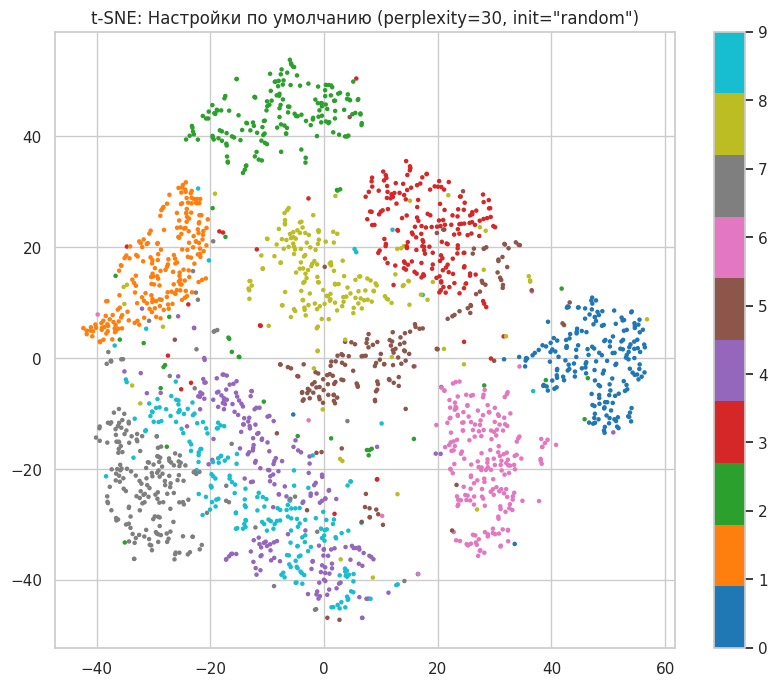

In [ ]:
tsne_default = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_default = tsne_default.fit_transform(X_sub)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_default[:, 0], X_tsne_default[:, 1], c=y_sub, cmap='tab10', s=5)
plt.title('t-SNE: Настройки по умолчанию (perplexity=30, init="random")')
plt.colorbar(scatter)
plt.show()

Для честности уберем "подцветку"

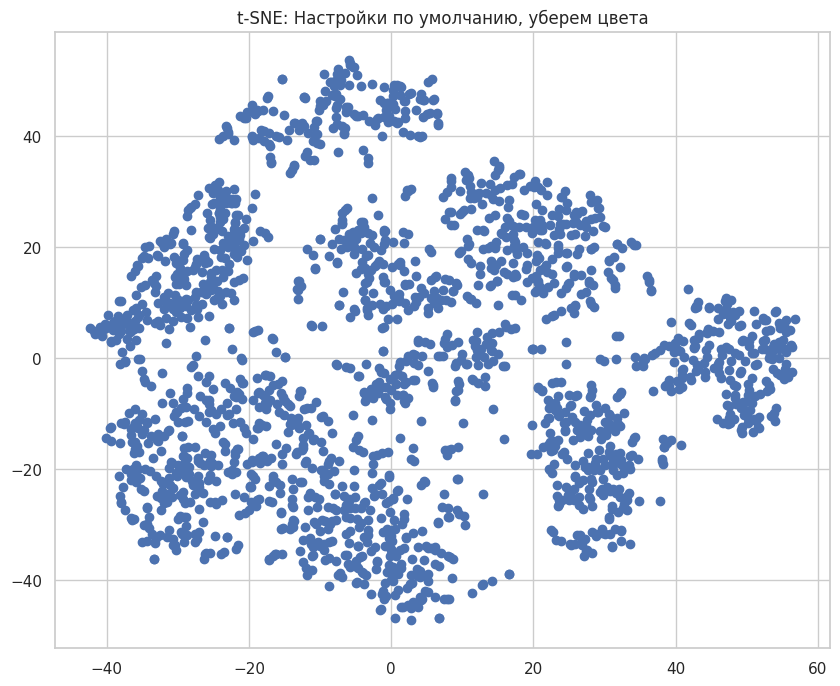

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_default[:, 0], X_tsne_default[:, 1])
plt.title('t-SNE: Настройки по умолчанию, уберем цвета')
plt.show()

# Perplexity

Perplexity можно неформально интерпретировать как «эффективное количество соседей». Типичные значения: от 5 до 50.

- Маленькая perplexity → алгоритм фокусируется на очень близких соседях → образуются мелкие кластеры, возможно, слишком «разорванные».
- Большая perplexity → учитываются более глобальные структуры → кластеры могут сливаться, но сохраняется более глобальная картина.

  0%|          | 0/5 [00:00<?, ?it/s]

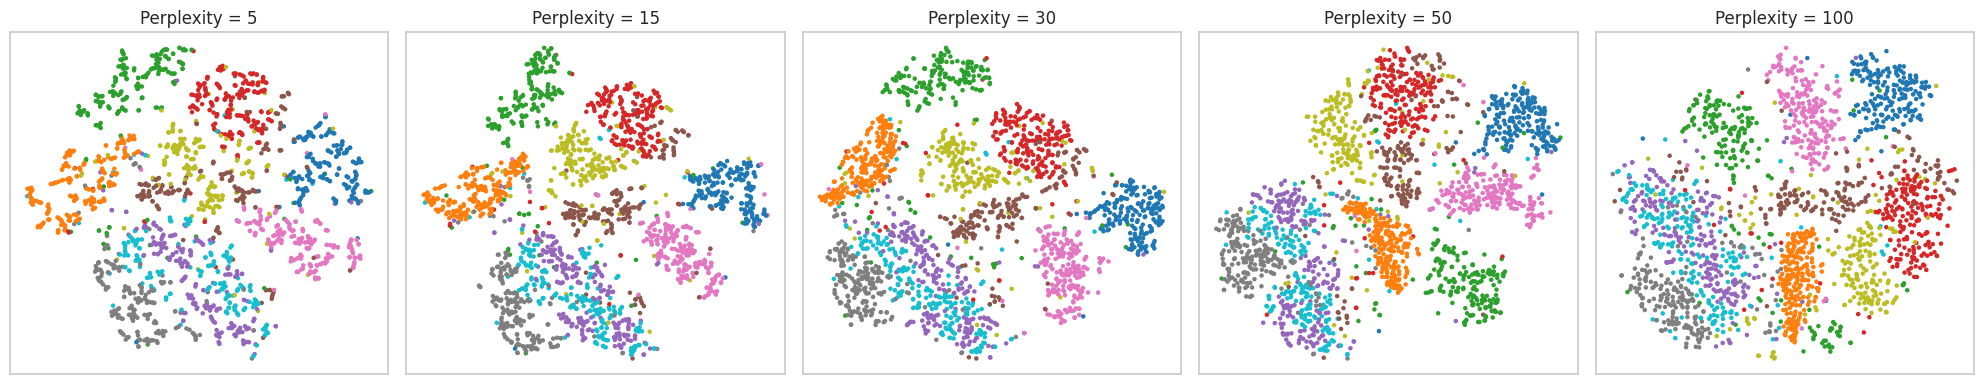

In [ ]:
perplexities = [5, 15, 30, 50, 100]

fig, axes = plt.subplots(1, len(perplexities), figsize=(20, 4))
for i, perp in tqdm(enumerate(perplexities), total=len(perplexities)):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, max_iter=1000)
    X_tsne = tsne.fit_transform(X_sub)
    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap='tab10', s=5)
    axes[i].set_title(f'Perplexity = {perp}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Начальная инициализация

t-SNE начинает оптимизацию с некоторой начальной конфигурации.

- `init="random"` — точки инициализируются случайно. Результат может зависеть от `random_state`, и сходимость может быть медленной.
- `init="pca"` — точки инициализируются с помощью PCA. Ускоряет сходимость и часто даёт более стабильный результат.

  0%|          | 0/2 [00:00<?, ?it/s]

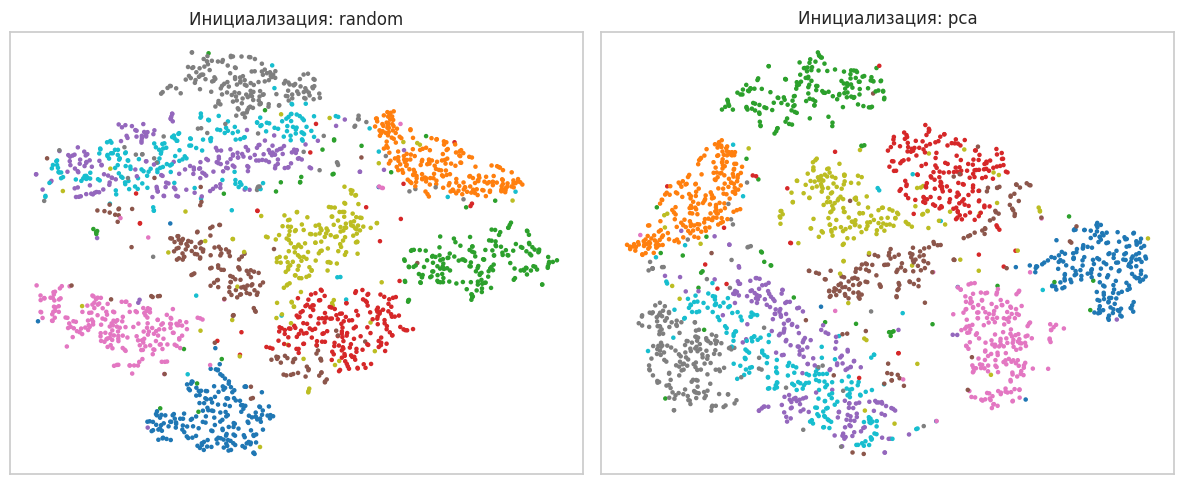

In [ ]:
inits = ['random', 'pca']
fig, axes = plt.subplots(1, len(inits), figsize=(12, 5))

for i, init in tqdm(enumerate(inits), total=len(inits)):
    tsne = TSNE(n_components=2, init=init, random_state=42, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(X_sub)
    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap='tab10', s=5)
    axes[i].set_title(f'Инициализация: {init}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Число итераций

t-SNE использует градиентный спуск. По умолчанию — 1000 итераций, но иногда этого мало для сходимости.

  0%|          | 0/4 [00:00<?, ?it/s]

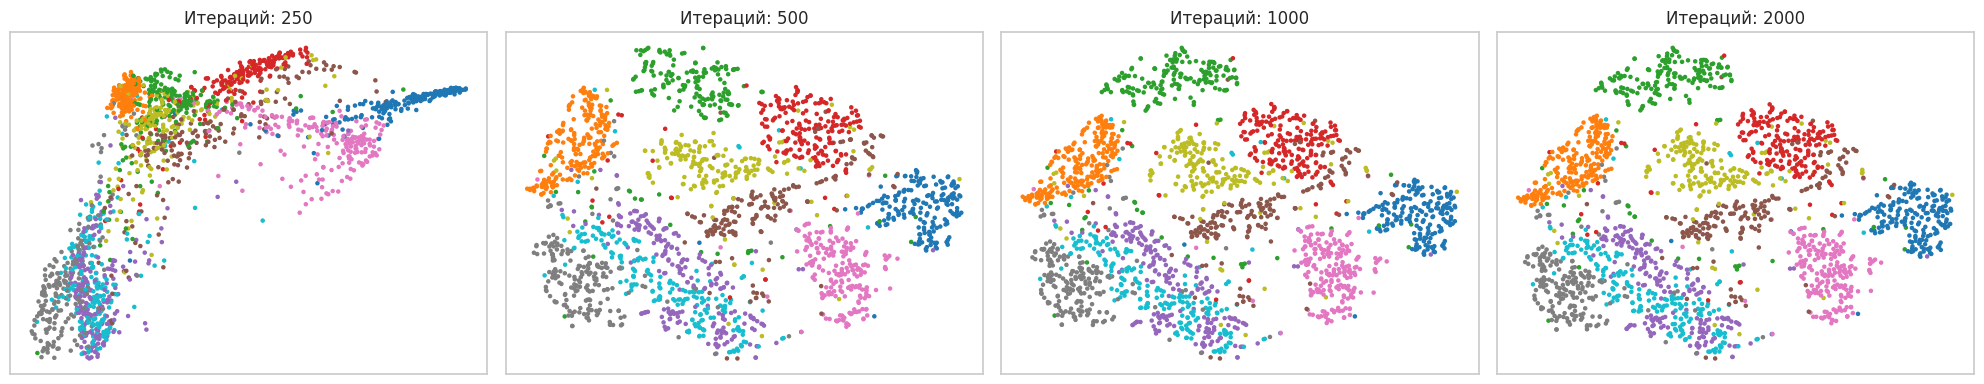

In [ ]:
n_iters = [250, 500, 1000, 2000]

fig, axes = plt.subplots(1, len(n_iters), figsize=(20, 4))
for i, max_iter in tqdm(enumerate(n_iters), total=len(n_iters)):
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42, max_iter=max_iter)
    X_tsne = tsne.fit_transform(X_sub)
    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap='tab10', s=5)
    axes[i].set_title(f'Итераций: {max_iter}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Early exaggeration и learning rate

Параметр `early_exaggeration`

Определяет, насколько «сжатыми» будут естественные кластеры из исходного пространства в проекции и сколько свободного пространства будет между ними. При больших значениях расстояние между кластерами в проекции увеличивается. Выбор этого параметра не является критичным. Однако, если в начальной фазе оптимизации значение функции стоимости (cost function) начинает расти, возможно, слишком велики либо параметр `early_exaggeration`, либо `learning rate`.

  0%|          | 0/4 [00:00<?, ?it/s]

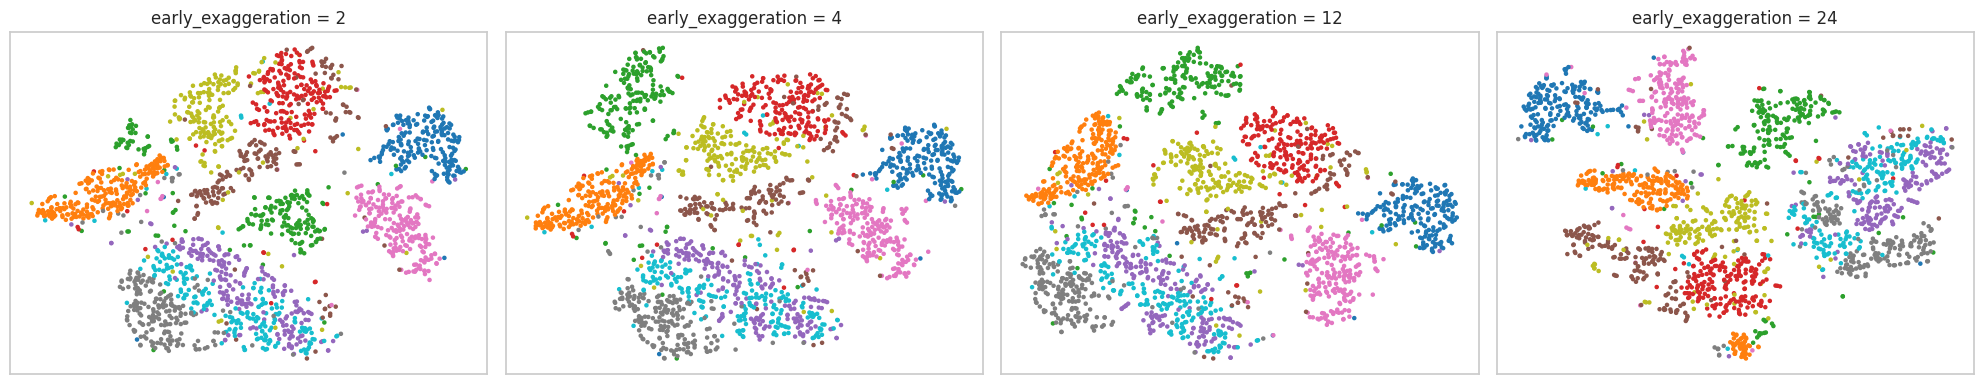

In [ ]:
early_exag_values = [2, 4, 12, 24]

fig, axes = plt.subplots(1, len(early_exag_values), figsize=(20, 4))
for i, exag in tqdm(enumerate(early_exag_values), total=len(early_exag_values)):
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        init='pca',
        random_state=42,
        max_iter=1000,
        learning_rate=200,
        early_exaggeration=exag
    )
    X_tsne = tsne.fit_transform(X_sub)
    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap='tab10', s=5)
    axes[i].set_title(f'early_exaggeration = {exag}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Параметр `learning_rate`

В t-SNE значение learning rate обычно находится в диапазоне $[10.0, 1000.0]$.  

- Если learning rate слишком велик, данные могут выглядеть как «шар», в котором почти каждая точка находится примерно на одинаковом расстоянии от своих ближайших соседей.  
- Если learning rate слишком мал, большинство точек окажутся сжатыми в плотное облако, и лишь несколько выбросов будут находиться в стороне.  
- Если оптимизация застревает в плохом локальном минимуме, увеличение learning rate может помочь выйти из него.

  0%|          | 0/5 [00:00<?, ?it/s]

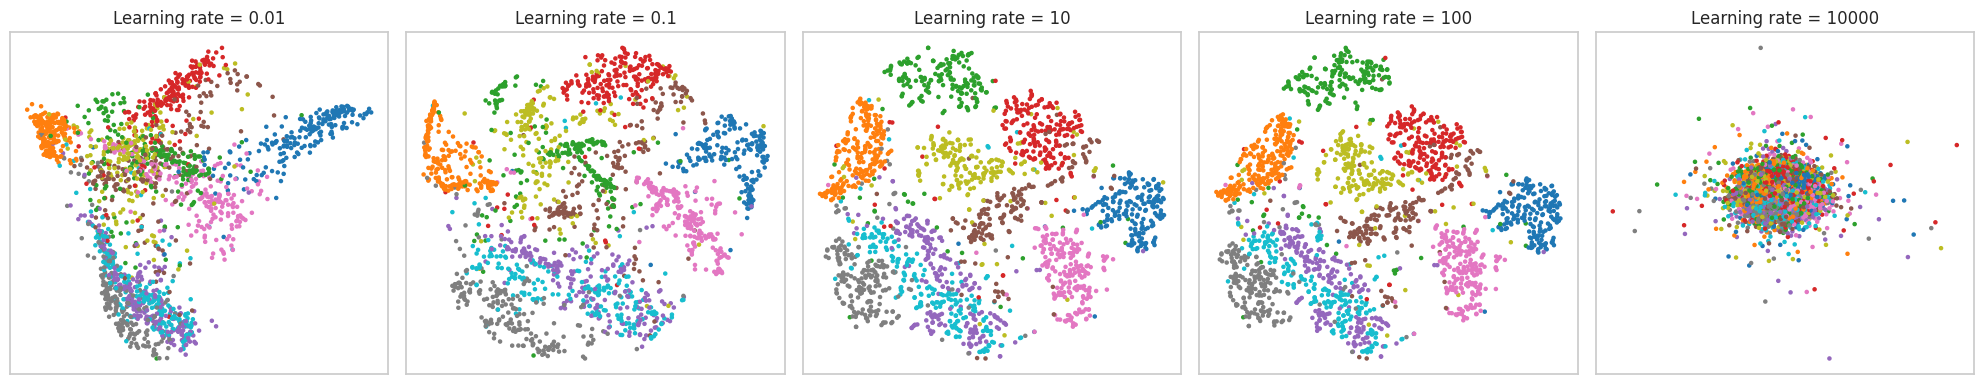

In [ ]:
learning_rates = [0.01, 0.1, 10, 100, 10000]

fig, axes = plt.subplots(1, len(learning_rates), figsize=(20, 4))
for i, lr in tqdm(enumerate(learning_rates), total=len(learning_rates)):
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42,
                max_iter=1000, learning_rate=lr)
    X_tsne = tsne.fit_transform(X_sub)
    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap='tab10', s=5)
    axes[i].set_title(f'Learning rate = {lr}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# [OpenTSNE](https://opentsne.readthedocs.io/en/latest/index.html)

С библиотечной реализацией t_SNE в sklearn все хорошо, но можно получить более расширенный функционал. Для этого можно воспользоваться библиотекой OpenTSNE.

OpenTSNE — это достаточно большоая библиотека, реализующая модель t-SNE. Настоятельно рекомендуем ознакомиться с документацией. Там можно почерпнуть массу интересной и полезной информации по рассматриваемой теме. В том числе библиотека позволяет применять полученное преобразование к новым данным.

In [ ]:
!pip install -q openTSNE
from openTSNE import TSNE as openTSNE
from sklearn.model_selection import train_test_split

Разделим данные на тренировочную и тестовую части

In [ ]:
N_SAMPLES = 10000
indices = np.random.choice(X.shape[0], N_SAMPLES, replace=False)
X_sub = X[indices]
y_sub = y[indices]

X_train, X_test, y_train, y_test = train_test_split(X_sub,y_sub, test_size=0.2, random_state=42, stratify=y_sub)
tsne = openTSNE(
    perplexity=100,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

Обучим модель на тренировочных данных

In [ ]:
embedding_train = tsne.fit(X_train)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, perplexity=100, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 300 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 14.86 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.86 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.55 seconds
===> Running optimization with exaggeration=12.00, lr=666.67 for 250 iterations...
Iteration   50, KL divergence 3.9261, 50 iterations in 4.1814 sec
Iteration  100, KL divergence 3.9614, 50 iterations in 5.2805 sec
Iteration  150, KL divergence 3.9621, 50 iterations in 4.1529 sec
Iteration  200, KL divergence 3.9621, 50 iterations in 4.2307 sec
Iteration  250, KL divergence 3.9621, 50 iterations in 5.3094 sec
   --> Time elapsed: 23.16 seconds
===> Running optimizat

Применим модель для тестовых данных

In [ ]:
embedding_test = embedding_train.transform(X_test)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 1.08 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 22369.2732, 50 iterations in 0.8738 sec
Iteration  100, KL divergence 22284.2317, 50 iterations in 0.8744 sec
Iteration  150, KL divergence 22259.5464, 50 iterations in 0.8732 sec
Iteration  200, KL divergence 22248.1134, 50 iterations in 0.8768 sec
Iteration  250, KL divergence 22236.2209, 50 iterations in 1.4733 sec
   --> Time elapsed: 4.97 seconds


<Axes: >

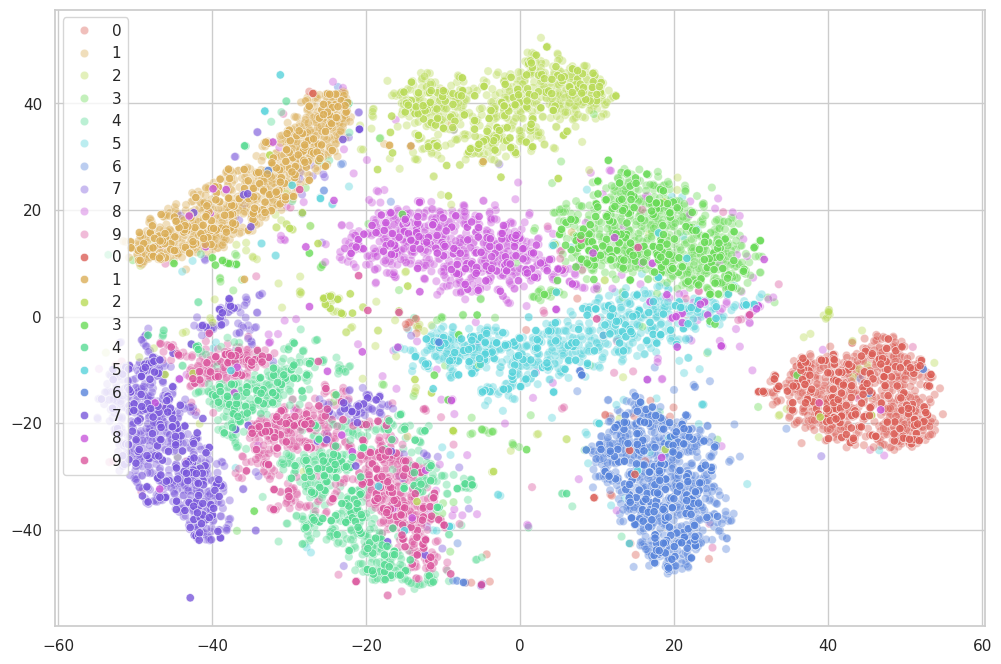

In [ ]:
plt.rcParams["figure.figsize"] = (12,8)

sns.scatterplot(x=embedding_train[:,0], y=embedding_train[:,1], palette=sns.color_palette("hls", 10), hue=y_train, alpha=0.4)
sns.scatterplot(x=embedding_test[:,0], y=embedding_test[:,1], hue=y_test, palette=sns.color_palette("hls", 10), alpha=0.8)

# TODO примеры визуализации эмбеддингов

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# @title Функция визуализации t-SNE
def plot_tsne(embeddings, labels=None, title="t-SNE"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    X = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    if labels is not None:
        scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10')
        plt.legend(*scatter.legend_elements(), title="Классы")
    else:
        plt.scatter(X[:, 0], X[:, 1])
    plt.title(title)
    plt.show()

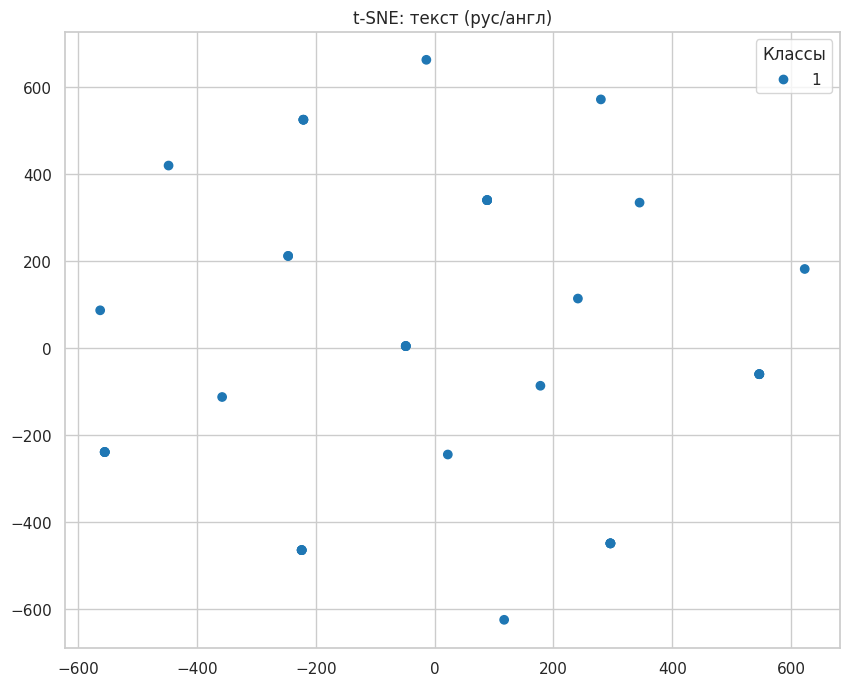

In [ ]:
# @title Текст → эмбеддинги
from sentence_transformers import SentenceTransformer

# Пример текстов (на русском и английском)
texts = [
    "Я люблю машинное обучение",
    "I love machine learning",
    "Погода сегодня прекрасная",
    "The weather is wonderful today",
    "Как пройти к ближайшей станции?",
    "How do I get to the nearest station?",
    "Кофе помогает работать",
    "Coffee helps me work",
    "Я люблю машинное обучение",
    "I love machine learning",
    "Погода сегодня прекрасная",
    "The weather is wonderful today",
    "Как пройти к ближайшей станции?",
    "How do I get to the nearest station?",
    "Кофе помогает работать",
    "Coffee helps me work",
    "Я люблю машинное обучение",
    "I love machine learning",
    "Погода сегодня прекрасная",
    "The weather is wonderful today",
    "Как пройти к ближайшей станции?",
    "How do I get to the nearest station?",
    "Кофе помогает работать",
    "Coffee helps me work",
    "Я люблю машинное обучение",
    "I love machine learning",
    "Погода сегодня прекрасная",
    "The weather is wonderful today",
    "Как пройти к ближайшей станции?",
    "How do I get to the nearest station?",
    "Кофе помогает работать",
    "Coffee helps me work",
    "Я люблю машинное обучение",
    "I love machine learning",
    "Погода сегодня прекрасная",
    "The weather is wonderful today",
    "Как пройти к ближайшей станции?",
    "How do I get to the nearest station?",
    "Кофе помогает работать",
    "Coffee helps me work",
]

# Загрузка модели
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(texts)

# Тексты на русском/английском будем кодировать метками
labels = [0 if t[0].islower() else 1 for t in texts]  # упрощённо

plot_tsne(embeddings, labels=labels, title="t-SNE: текст (рус/англ)")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


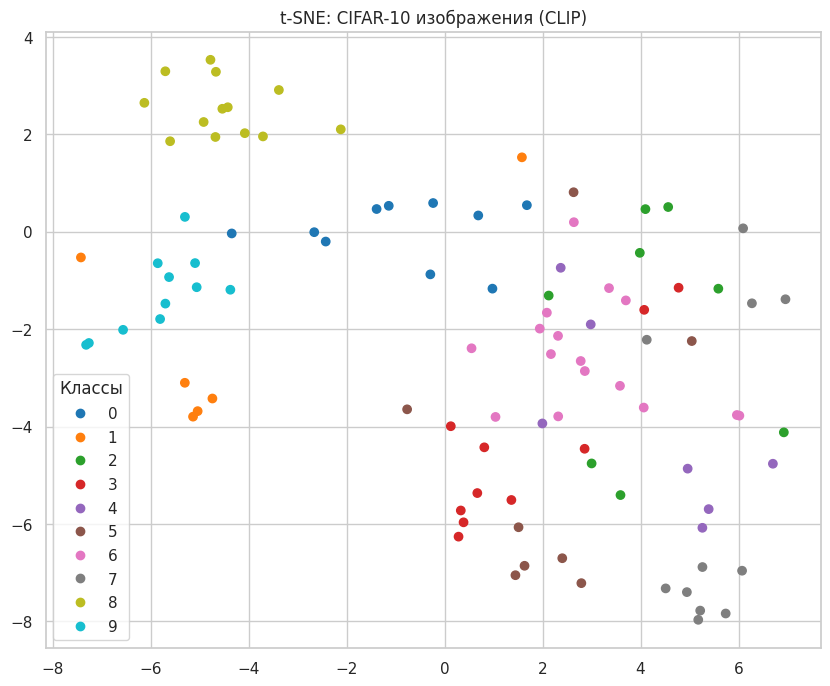

In [ ]:
# @title Картинки → эмбеддинги (на примере CIFAR-10)
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import torch

# Загрузим CIFAR-10 (10 классов по 32x32)
dataset = load_dataset("cifar10", split="test[:100]")  # 100 картинок

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

images = [img for img in dataset['img']]
labels = dataset['label']

inputs = processor(images=images, return_tensors="pt", padding=True)
with torch.no_grad():
    image_features = model.get_image_features(**inputs)

embeddings = image_features.numpy()
plot_tsne(embeddings, labels=labels, title="t-SNE: CIFAR-10 изображения (CLIP)")

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


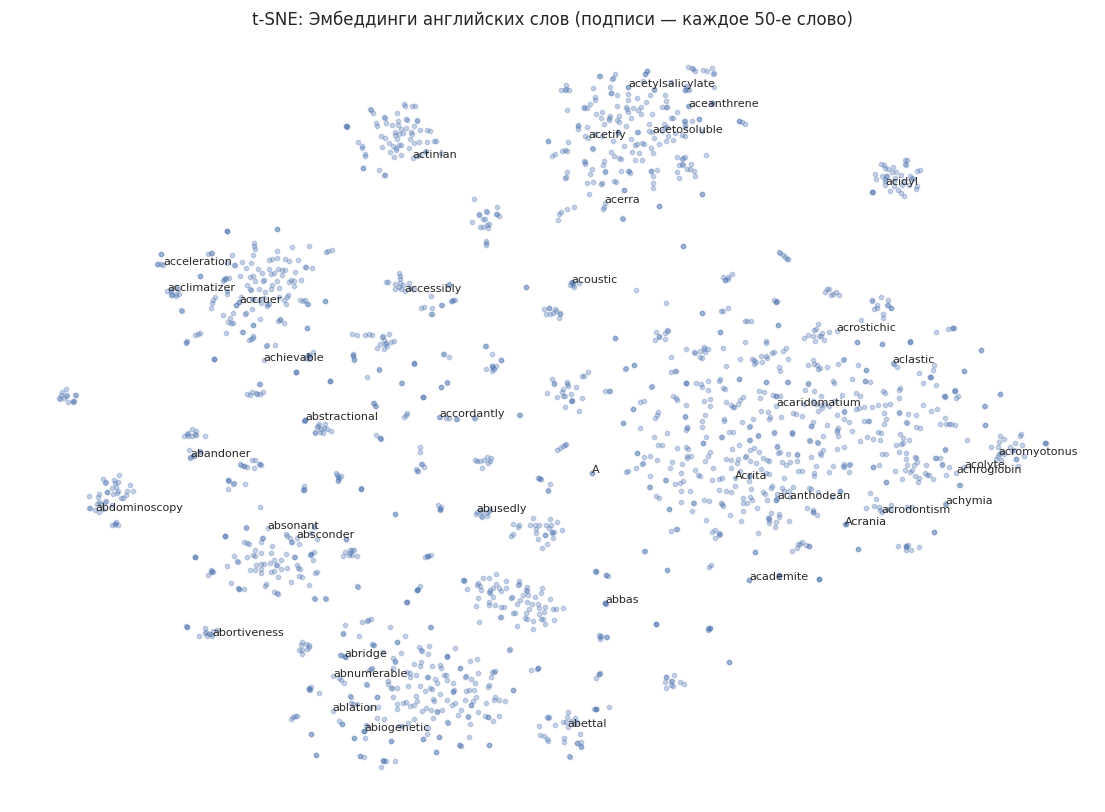

In [ ]:
# @title Эмбеддинги слов и t-SNE
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import words

# Загрузим английский словарь (около 40k слов)
nltk.download('words', quiet=True)
word_list = [w for w in words.words() if w.isalpha()][:2000]  # первые 2000 слов

# Эмбеддинги
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(word_list)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, init='pca')
X_tsne = tsne.fit_transform(embeddings)

# Визуализация с подписями (покажем каждое 50-е слово для читаемости)
plt.figure(figsize=(14, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.3, s=10)

step = 50
for i in range(0, len(word_list), step):
    plt.text(X_tsne[i, 0], X_tsne[i, 1], word_list[i], fontsize=8)

plt.title('t-SNE: Эмбеддинги английских слов (подписи — каждое 50-е слово)')
plt.axis('off')
plt.show()